# Dependencies

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from keras import optimizers
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.layers import Dense, Dropout, BatchNormalization, Activation

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score

# Set seeds to make the experiment more reproducible.
from tensorflow import set_random_seed
from numpy.random import seed
set_random_seed(0)
seed(0)

%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

Using TensorFlow backend.


# Load data

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

In [3]:
print('Train set shape:', train.shape)
print('Test set shape:', test.shape)
print('Train set overview:')
display(train.head())

Train set shape: (262144, 258)
Test set shape: (131073, 257)
Train set overview:


,id,muggy-smalt-axolotl-pembus,dorky-peach-sheepdog-ordinal,slimy-seashell-cassowary-goose,snazzy-harlequin-chicken-distraction,frumpy-smalt-mau-ordinal,stealthy-beige-pinscher-golden,chummy-cream-tarantula-entropy,hazy-emerald-cuttlefish-unsorted,nerdy-indigo-wolfhound-sorted,leaky-amaranth-lizard-sorted,ugly-tangerine-chihuahua-important,shaggy-silver-indri-fimbus,flaky-chocolate-beetle-grandmaster,squirrely-harlequin-sheep-sumble,freaky-tan-angelfish-noise,lousy-plum-penguin-sumble,bluesy-rose-wallaby-discard,baggy-copper-oriole-dummy,stealthy-scarlet-hound-fepid,greasy-cinnamon-bonobo-contributor,cranky-cardinal-dogfish-ordinal,snippy-auburn-vole-learn,greasy-sepia-coral-dataset,flabby-tangerine-fowl-entropy,lousy-smalt-pinscher-dummy,bluesy-brass-chihuahua-distraction,goopy-eggplant-indri-entropy,homey-sepia-bombay-sorted,homely-ruby-bulldog-entropy,hasty-blue-sheep-contributor,blurry-wisteria-oyster-master,snoopy-auburn-dogfish-expert,stinky-maroon-blue-kernel,bumpy-amaranth-armadillo-important,slaphappy-peach-oyster-master,dorky-tomato-ragdoll-dataset,messy-mauve-wolverine-ordinal,geeky-pumpkin-moorhen-important,crabby-teal-otter-unsorted,...,beady-mauve-frog-distraction,surly-brass-maltese-ordinal,beady-asparagus-opossum-expert,beady-rust-impala-dummy,droopy-amethyst-dachshund-hint,homey-crimson-budgerigar-grandmaster,droopy-cardinal-impala-important,woozy-apricot-moose-hint,paltry-sapphire-labradoodle-dummy,crappy-carmine-eagle-entropy,greasy-magnolia-spider-grandmaster,crabby-carmine-flounder-sorted,skimpy-copper-fowl-grandmaster,hasty-seashell-woodpecker-hint,snappy-purple-bobcat-important,thirsty-carmine-corgi-ordinal,homely-auburn-reindeer-unsorted,crappy-beige-tiger-fepid,cranky-auburn-swan-novice,chewy-bistre-buzzard-expert,skinny-cyan-macaque-pembus,slimy-periwinkle-otter-expert,snazzy-burgundy-clam-novice,cozy-ochre-gorilla-gaussian,homey-sangria-wolfhound-dummy,snazzy-asparagus-hippopotamus-contributor,paltry-red-hamster-sorted,zippy-dandelion-insect-golden,baggy-coral-bandicoot-unsorted,goopy-lavender-wolverine-fimbus,wheezy-myrtle-mandrill-entropy,wiggy-lilac-lemming-sorted,gloppy-cerise-snail-contributor,woozy-silver-havanese-gaussian,jumpy-thistle-discus-sorted,muggy-turquoise-donkey-important,blurry-buff-hyena-entropy,bluesy-chocolate-kudu-fepid,gamy-white-monster-expert,target
0,707b395ecdcbb4dc2eabea00e4d1b179,-2.070654,1.018160,0.228643,0.857221,0.052271,0.230303,-6.385090,0.439369,-0.721946,-0.227027,0.575964,1.541908,1.745286,-0.624271,3.600958,1.176489,-0.182776,-0.228391,1.682263,-0.833236,-4.377688,-5.372410,-0.477742,-0.179005,-0.516475,0.127391,-0.857591,-0.461500,2.160303,-2.118371,0.515493,-1.201493,-0.027377,-1.154024,0.753204,-0.179651,-0.807341,-1.663626,0.893806,...,-1.829848,2.347131,0.082462,-1.012654,0.593752,2.904654,-0.428974,-0.919979,2.849575,-0.906744,0.729459,0.386140,0.319814,-0.407682,-0.170667,-1.242919,-1.719046,-0.132395,-0.368991,-5.112553,-2.085988,-0.897257,1.080671,-0.273262,0.342824,0.640177,-0.415298,-0.483126,-0.080799,2.416224,0.351895,0.618824,-1.542423,0.598175,0.611757,0.678772,0.247059,-0.806677,-0.193649,0
1,5880c03c6582a7b42248668e56b4bdec,-0.491702,0.082645,-0.011193,1.071266,-0.346347,-0.082209,0.110579,-0.382374,-0.229620,0.783980,-1.280579,-1.003480,-7.753201,-1.320547,0.919078,-1.036068,0.030213,0.910172,-0.905345,0.646641,-0.465291,-0.531735,-0.756781,0.193724,0.224277,-0.474412,1.885805,0.205439,-6.481422,1.035620,-0.453623,0.375936,-0.320670,-0.144646,-0.220129,0.577826,-0.360512,-0.600107,0.008111,...,0.982205,-1.161978,0.532269,1.133215,0.003503,-1.390962,0.158572,0.143794,-0.317185,1.017192,-0.395342,-0.642357,-0.627209,0.257271,-1.461564,0.325613,1.628369,0.640040,0.750735,1.164573,0.900373,0.063489,0.948158,0.273014,-1.269147,-0.251101,-2.271731,-0.044167,-0.443766,-1.144794,-0.645115,-1.246090,2.613357,-0.479664,1.581289,0.931258,0.151937,-0.766595,0.474351,0
2,4ccbcb3d13e5072ff1d9c61afe2c4f77,-1.680473,0.860529,-1.076195,0.740124,3.678445,0.28855

On both our train and test sets all columns are numerical, and we also don't have any missing data.

# EDA

## Target distribution

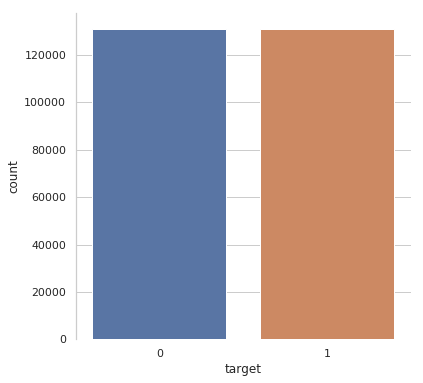

In [4]:
f, ax = plt.subplots(figsize=(6, 6))
ax = sns.countplot(x="target", data=train, label="Label count")
sns.despine(bottom=True)

Also we have a balanced target distribution.

## Feature distribution

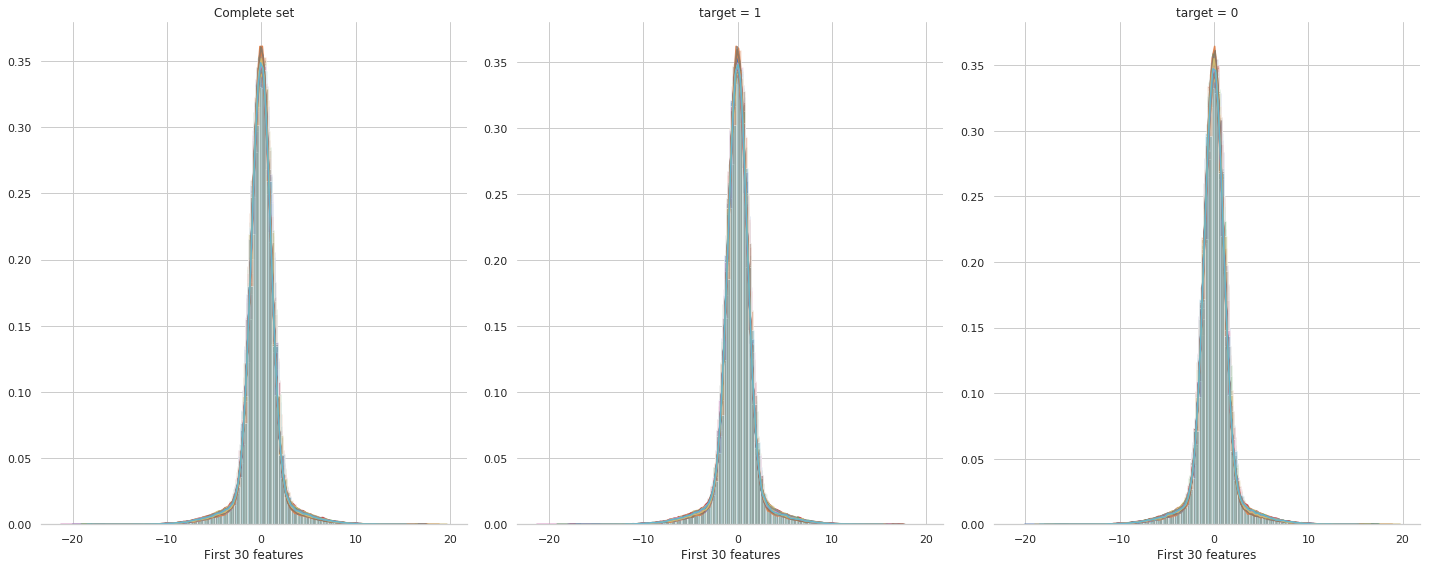

In [5]:
def plot_distribution():
    f, axes = plt.subplots(1, 3, figsize=(20, 8), sharex=True)
    for feature in train.columns[1:31]:
        sns.distplot(train[feature], ax=axes[0], axlabel='First 30 features').set_title("Complete set")
        sns.distplot(train[train['target']==1][feature], ax=axes[1], axlabel='First 30 features').set_title("target = 1")
        sns.distplot(train[train['target']==0][feature], ax=axes[2], axlabel='First 30 features').set_title("target = 0")
    sns.despine(left=True)
    plt.tight_layout()

plot_distribution()

The features seems to be normalized.

## Process data for model

### Turn "wheezy-copper-turtle-magic" into a categorical feature

In [6]:
train = pd.concat([train, pd.get_dummies(train['wheezy-copper-turtle-magic'], prefix='magic', drop_first=True)], axis=1).drop(['wheezy-copper-turtle-magic'], axis=1)
test = pd.concat([test, pd.get_dummies(test['wheezy-copper-turtle-magic'], prefix='magic', drop_first=True)], axis=1).drop(['wheezy-copper-turtle-magic'], axis=1)

### Train/validation random split (80% train / 20% validation)

In [7]:
labels = train['target']
train.drop('target', axis=1, inplace=True)
train.drop('id', axis=1, inplace=True)
test.drop('id', axis=1, inplace=True)

X_train, X_val, Y_train, Y_val = train_test_split(train, labels, test_size=0.2, random_state=1)

### Normalize data using MinMaxScaler

In [8]:
non_cat_features = list(train.filter(regex='^(?!magic_)'))
scaler = MinMaxScaler()
X_train[non_cat_features] = scaler.fit_transform(X_train[non_cat_features])
X_val[non_cat_features] = scaler.transform(X_val[non_cat_features])
test[non_cat_features] = scaler.transform(test[non_cat_features])

# Model

## Model parameters

In [9]:
BATCH_SIZE = 128
EPOCHS = 30
LEARNING_RATE = 0.01
ES_PATIENCE = 5

In [10]:
model = Sequential()
model.add(Dense(1024, input_dim=X_train.shape[1]))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=ES_PATIENCE)
callback_list = [es]

optimizer = optimizers.Adam(lr=0.0001)
model.compile(optimizer=optimizer, loss="binary_crossentropy",  metrics=['binary_accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              785408    
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
activation_1 (Activation)    (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               262400    
_________________________________________________________________
batch_normalization_2

In [11]:
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), 
                    callbacks=callback_list, 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 209715 samples, validate on 52429 samples
Epoch 1/30
 - 21s - loss: 0.7833 - binary_accuracy: 0.5054 - val_loss: 0.6878 - val_binary_accuracy: 0.5402
Epoch 2/30
 - 20s - loss: 0.7194 - binary_accuracy: 0.5202 - val_loss: 0.6826 - val_binary_accuracy: 0.5693
Epoch 3/30
 - 20s - loss: 0.6963 - binary_accuracy: 0.5354 - val_loss: 0.6803 - val_binary_accuracy: 0.5820
Epoch 4/30
 - 20s - loss: 0.6859 - binary_accuracy: 0.5517 - val_loss: 0.6771 - val_binary_accuracy: 0.5865
Epoch 5/30
 - 19s - loss: 0.6780 - binary_accuracy: 0.5705 - val_loss: 0.6705 - val_binary_accuracy: 0.5997
Epoch 6/30
 - 19s - loss: 0.6684 - binary_accuracy: 0.5898 - val_loss: 0.6577 - val_binary_accuracy: 0.6297
Epoch 7/30
 - 19s - loss: 0.6540 - binary_accuracy: 0.6123 - val_loss: 0.6560 - val_binary_accuracy: 0.5923
Epoch 8/30
 - 19s - loss: 0.6358 - binary_accuracy: 0.6368 - val_loss: 0.6509 - val_binary_accuracy: 0.5965
Epoch 9/30
 - 19s - loss: 0.6182 - bi

### Model graph loss

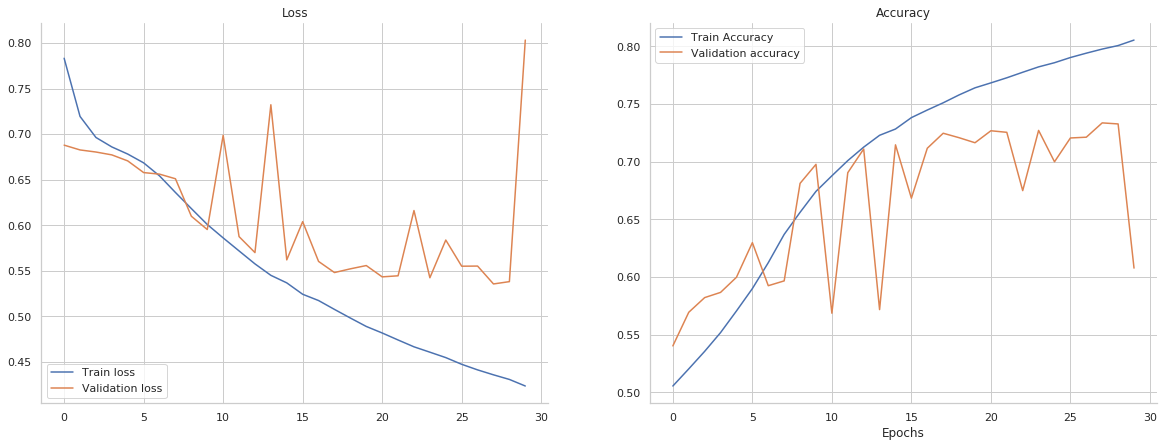

In [12]:
sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(20, 7))

ax1.plot(history.history['loss'], label='Train loss')
ax1.plot(history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history.history['binary_accuracy'], label='Train Accuracy')
ax2.plot(history.history['val_binary_accuracy'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()

# Model evaluation

## Confusion matrix

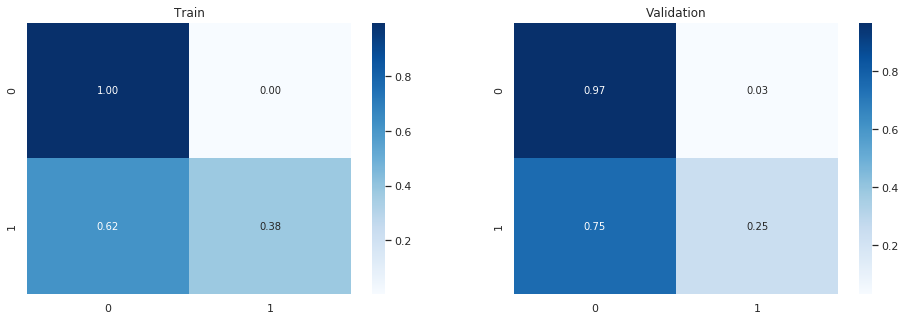

In [13]:
train_pred = model.predict_classes(X_train)
val_pred = model.predict_classes(X_val)

f, axes = plt.subplots(1, 2, figsize=(16, 5), sharex=True)
train_cnf_matrix = confusion_matrix(Y_train, train_pred)
val_cnf_matrix = confusion_matrix(Y_val, val_pred)

train_cnf_matrix_norm = train_cnf_matrix / train_cnf_matrix.sum(axis=1)[:, np.newaxis]
val_cnf_matrix_norm = val_cnf_matrix / val_cnf_matrix.sum(axis=1)[:, np.newaxis]

train_df_cm = pd.DataFrame(train_cnf_matrix_norm, index=[0, 1], columns=[0, 1])
val_df_cm = pd.DataFrame(val_cnf_matrix_norm, index=[0, 1], columns=[0, 1])

sns.heatmap(train_df_cm, annot=True, fmt='.2f', cmap="Blues", ax=axes[0]).set_title("Train")
sns.heatmap(val_df_cm, annot=True, fmt='.2f', cmap="Blues", ax=axes[1]).set_title("Validation")
plt.show()

## Metrics ROC AUC

In [14]:
print('Train AUC %.2f' % roc_auc_score(Y_train.values, train_pred))
print('Validation AUC %.2f' % roc_auc_score(Y_val.values, val_pred))

Train AUC 0.69
Validation AUC 0.61


# Test predictions

In [15]:
predictions = model.predict(test)
df = pd.read_csv('../input/sample_submission.csv')
df['target'] = predictions
df.to_csv('submission.csv', index=False)
df.head(10)

,id,target
0,1c13f2701648e0b0d46d8a2a5a131a53,0.406026
1,ba88c155ba898fc8b5099893036ef205,0.297863
2,7cbab5cea99169139e7e6d8ff74ebb77,0.299330
3,ca820ad57809f62eb7b4d13f5d4371a0,0.048772
4,7baaf361537fbd8a1aaa2c97a6d4ccc7,0.007759
5,8b3116e5e3e92e971dac305d1a093bf6,0.225391
6,35cfd7cab9bfa29bc963d1b8c94dd280,0.005694
7,83cf532df8ff4642a3e33a70fffdac37,0.199151
8,2e1350fe94ec9f2220bec5245e5e9265,0.555559
9,e62020afa72eb54a15725473e3a8475b,0.044808
